In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

In [2]:
sys.path.append("/global/home/users/yifengh3/VAE/EMD_VAE")

In [3]:
from utils import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K

import os
import os.path as osp
import sys
import json

import numpy as np
#from scipy import linalg as LA

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
# from colorspacious import cspace_converter
from collections import OrderedDict


import tensorflow.keras as keras
import tensorflow.keras.backend as K

import numpy as np
import pandas

2022-09-27 20:40:16.459380: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


1 Physical GPUs, 1 Logical GPUs


2022-09-27 20:40:17.533841: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-27 20:40:17.534605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-27 20:40:17.565321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-27 20:40:17.565350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-27 20:40:17.566750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-27 20:40:17.566778: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

In [4]:
import utils.VAE_model_tools_param
from utils.VAE_model_tools_param import build_and_compile_annealing_vae, betaVAEModel, reset_metrics, loss_tracker, myTerminateOnNaN

build TensorFlow with the appropriate compiler flags.
2022-09-27 20:40:17.579310: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-27 20:40:17.580597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-27 20:40:17.580617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-27 20:40:17.580632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-27 20:40:17.580645: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-09-27 20:40:17.580656: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] S

In [5]:
fn =  '/global/home/users/yifengh3/VAE/vec_data/B_background.h5'
vae_args_file = "/global/home/users/yifengh3/VAE/vec_data/vec_model_no_anneal/vae_args.dat"
model_dir = "/global/home/users/yifengh3/VAE/vec_data/vec_model_no_anneal"
numbatches = 1000

df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi, E.
# we only need first 200th entries, weight is not required here
numparts=50
data = df.values[:,:200]
print(data.shape)
data = data.reshape((-1,numparts,4))
data = data.astype(float)

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]
data[:,:,-1] = data[:,:,-1]/HT[:,None]

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),numparts,4))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
#sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data[:,:,:3]

numtrain = 500000
train_x = data_x[:numtrain]
train_y = data_y[:numtrain]
valid_x = data_x[numtrain:numtrain+100000]
valid_y = data_y[numtrain:numtrain+100000]

# train_output_dir = osp.join(model_dir,"end_beta_checkpoint") #create_dir(osp.join(output_dir, experiment_name))
train_output_dir = model_dir


with open(vae_args_file,'r') as f:
     vae_arg_dict = json.loads(f.read())

print("\n\n vae_arg_dict:", vae_arg_dict)

vae, encoder, decoder = build_and_compile_annealing_vae(**vae_arg_dict)

(907963, 206)
Memory in GB: 3.003594070672989
(907963, 200)


 vae_arg_dict: {'encoder_conv_layers': [1024, 1024, 1024, 1024], 'dense_size': [1024, 1024, 1024, 1024], 'decoder_sizes': [1024, 1024, 1024, 1024, 1024], 'numIter': 10, 'reg_init': 1.0, 'reg_final': 0.01, 'stopThr': 0.001, 'num_inputs': 4, 'num_particles_in': 50, 'latent_dim': 256, 'verbose': 1, 'dropout': 0.0, 'exponent': 2.0}
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 4)]      0                                            
___________________________________________________________________________________

2022-09-27 20:40:44.336582: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50, 4)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 1024)     5120        inputs[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 50, 1024)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 1024)     1049600     leaky_re_lu[0][0]                
________________________________________________________________________________________________

In [6]:
logbetas = np.linspace(1,-6,50).astype(np.float32)

In [7]:
model_dir = "/global/home/users/yifengh3/VAE/vec_data/vec_model_no_anneal"
model_name = "model_weights_end_1429_betar_1.0e+00.hdf5"

In [8]:
vae.load_weights(os.path.join(model_dir,model_name))

In [56]:
from pyjet import cluster

def get_clustered_pt_eta_phi(pts, locations,R=0.1):
    weights = pts
    outjet = locations
    myjet = np.zeros((weights.shape[-1]),dtype=([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')]))
    myjet['pT'] = weights
    myjet['eta'] = outjet[:,0]
    myjet['phi'] = outjet[:,1]
    sequence = cluster(myjet,R=R,p=0)
    jets = sequence.inclusive_jets()
    phis = np.array([np.mod(np.pi+jet.phi,2*np.pi)-np.pi for jet in jets])
    etas = np.array([jet.eta for jet in jets])
    pts = np.array([jet.pt for jet in jets])
    
    return pts, etas, phis

def get_jet_plot(jet,plot_title,numplot = 100, R=0.02,size=1000,save_dir = None): 
    """
    plots original jet and save as png file
    jet: Nonex50x3 jet input
    """
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i in range(numplot):
        outjet = jet[i,:,1:]
        weights = jet[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        plt.scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        plt.title("{} #{}".format(plot_title,i))
        plt.xlim(-np.pi,np.pi)
        plt.ylim(-5,5)
        plt.ylabel(r'$\eta$',fontsize=18)
        plt.xlabel(r'$\phi$',fontsize=18)
        if save_dir:
            plt.savefig(os.path.join(save_dir, "{}_{}.png".format(plot_title.replace(" ","_"),i)))
        plt.show()

def get_jet_plot_by_index(jet,plot_title,index , R=0.02,size=1000,save_dir = None): 
    """
    plots original jet and save as png file
    jet: Nonex50x3 jet input
    """
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i in index:
        outjet = jet[i,:,1:]
        weights = jet[i,:,0]
        pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
        plt.scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
        plt.title("{} #{}".format(plot_title,i))
        plt.xlim(-np.pi,np.pi)
        plt.ylim(-5,5)
        plt.ylabel(r'$\eta$',fontsize=18)
        plt.xlabel(r'$\phi$',fontsize=18)
        if save_dir:
            plt.savefig(os.path.join(save_dir, "{}_{}.png".format(plot_title.replace(" ","_"),i)))
        plt.show()
        
def get_mle_predict_plot(jet,plot_index, betas, R=0.02,size=1000,save_dir = None, show_image=False, origin_jet=None): 
    """
    plots original jet and save as png file
    jet: Nonex50x3 jet input
    """
    num_beta, num_plots, _, _ = jet.shape
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for valid_index in tqdm(range(num_plots)):
        if save_dir:
            os.makedirs(os.path.join(save_dir, "valid_plot_{}".format(plot_index[valid_index])))
        for beta_index in range(num_beta):
            outjet = jet[beta_index, valid_index,:,1:]
            weights = jet[beta_index, valid_index,:,0]
            plt.figure()
            pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
            plt.scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0)
            plt.title("plot#{} at logbeta = {:.4f}".format(plot_index[valid_index],betas[beta_index]))
            if not isinstance(origin_jet, type(None)):
                outjet = origin_jet[valid_index,:,1:]
                weights = origin_jet[valid_index,:,0]
                pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
                plt.scatter(phis, etas, s = pts*size, alpha = 0.3,linewidths=0, c="red", label="original jet")
            plt.ylabel(r'$\eta$',fontsize=18)
            plt.xlabel(r'$\phi$',fontsize=18)
            if save_dir:
                plt.savefig(os.path.join(
                    save_dir, 
                    "valid_plot_{}".format(plot_index[valid_index]),"{}.png".format("{}_plot#{} at logbeta = {:.4f}".format(beta_index,plot_index[valid_index],betas[beta_index]).replace(" ","_"))))
            if show_image:
                plt.show()
            plt.close()
            
def plot_jet(original_jet, recon_jet, plot_title, R=0.02,size=1000,save_name = None): 
    """
    plots original jet and save as png file
    jet: Nonex50x3 jet input
    """
    plt.figure(figsize=(10,10))
#     if save_dir and not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    outjet = original_jet[:,1:]
    weights = original_jet[:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
    plt.scatter(phis, etas, s = pts*size, alpha = 0.5,linewidths=0, label="original jets", c="red")
    outjet = recon_jet[:,1:]
    weights = recon_jet[:,0]
    pts, etas, phis = get_clustered_pt_eta_phi(weights, outjet,R=R)
    plt.scatter(phis, etas, s = pts*size, alpha = 0.7,linewidths=0, label="reconstructed jets", c="blue")
    
    plt.title("{}".format(plot_title))
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-5,5)
    plt.ylabel(r'$\eta$',fontsize=18)
    plt.xlabel(r'$\phi$',fontsize=18)
    
    plt.legend(loc='upper right')
    if save_name:
        plt.savefig(save_name, dpi=200)
    plt.show()


In [10]:
interesting_validation_index = [0,2,4,7,9,13,17,19,20,21,24,33,40,42,50]
interesting_xs = valid_x[interesting_validation_index]
interesting_ys = valid_y[interesting_validation_index]
results= []
for logbeta in logbetas:
    results.append(vae.predict_mle([interesting_xs,np.ones(len(interesting_xs))*logbeta]))
res = np.array(results)

2022-09-27 20:40:59.779318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [24]:
res[0,0].reshape([1,*res[0,0].shape]).shape

(1, 50, 3)

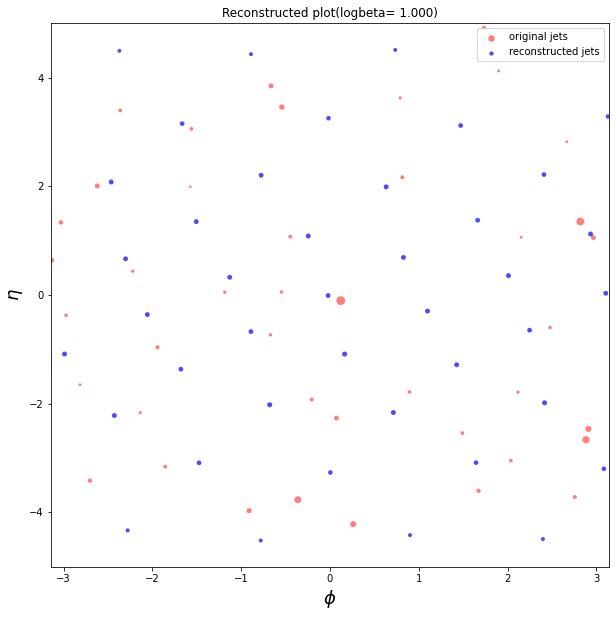

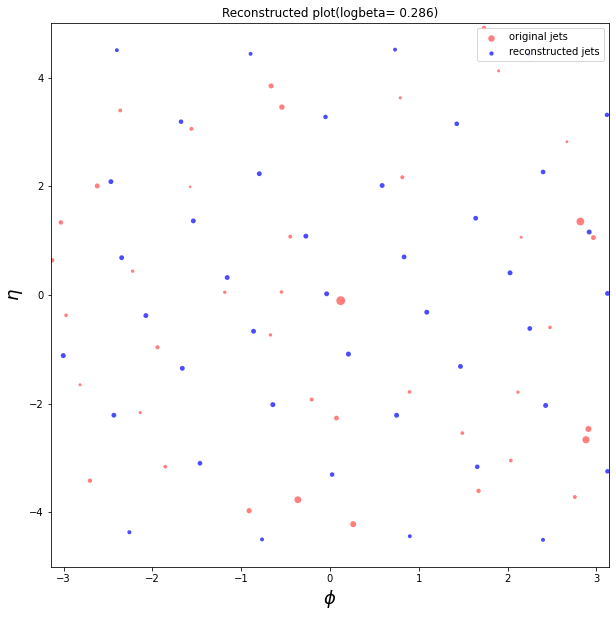

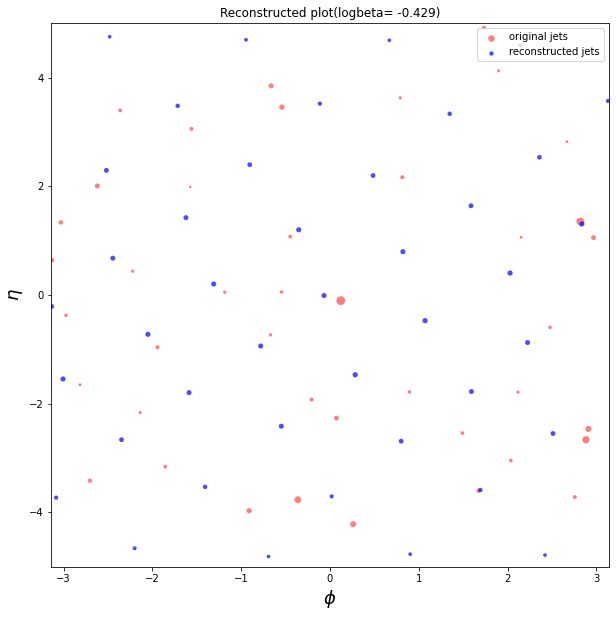

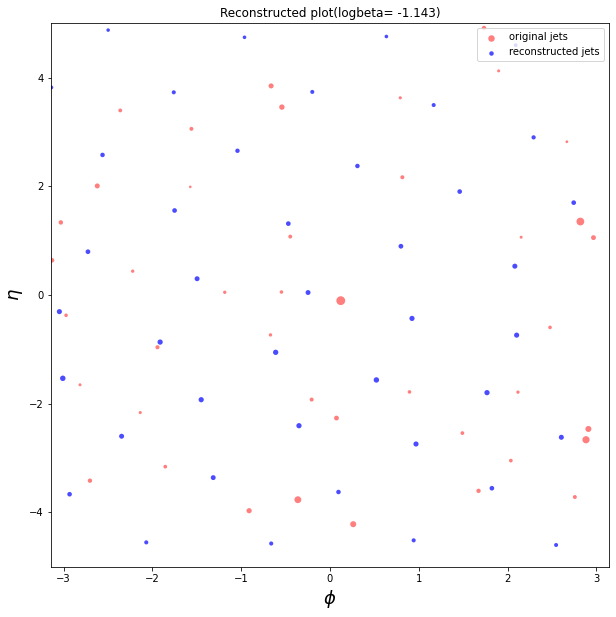

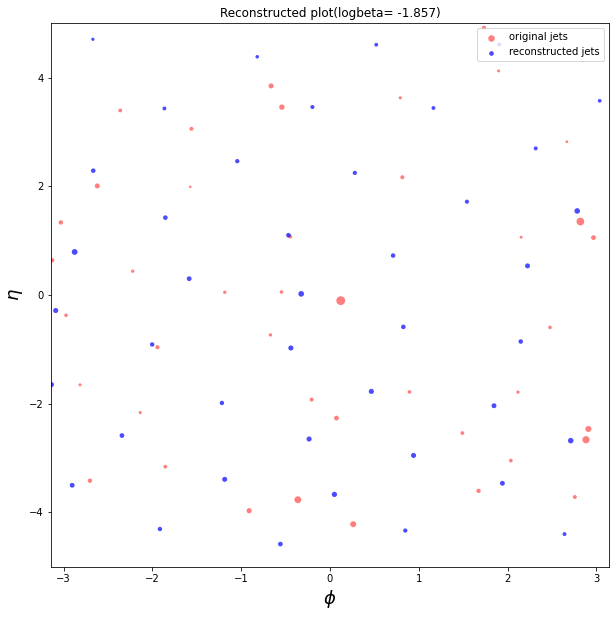

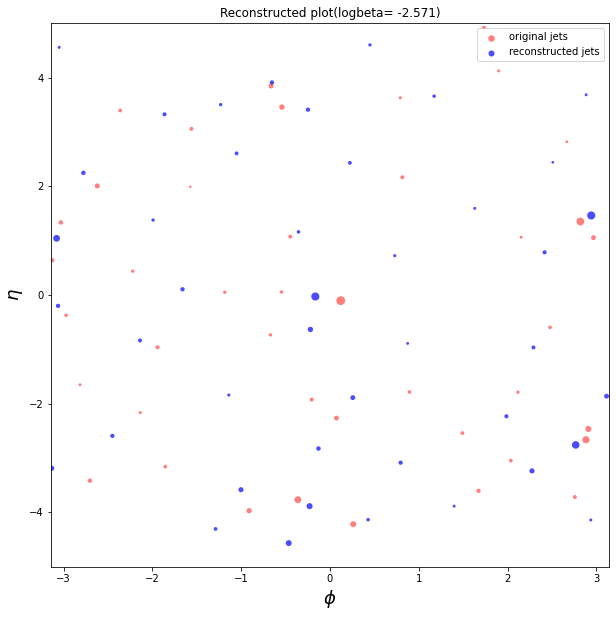

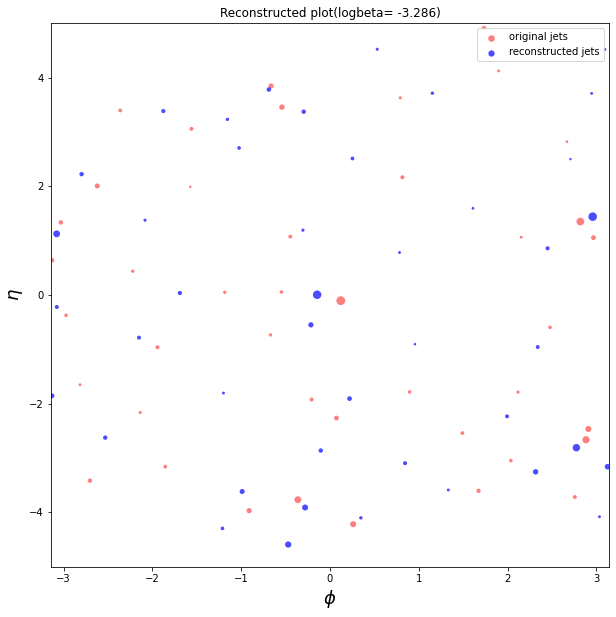

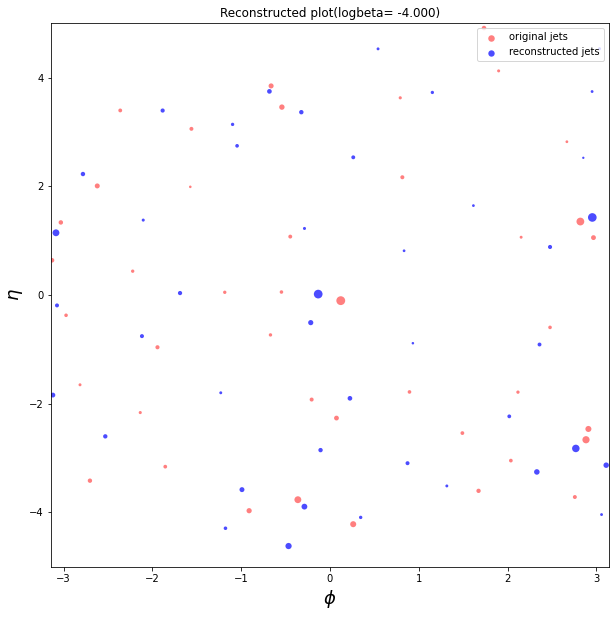

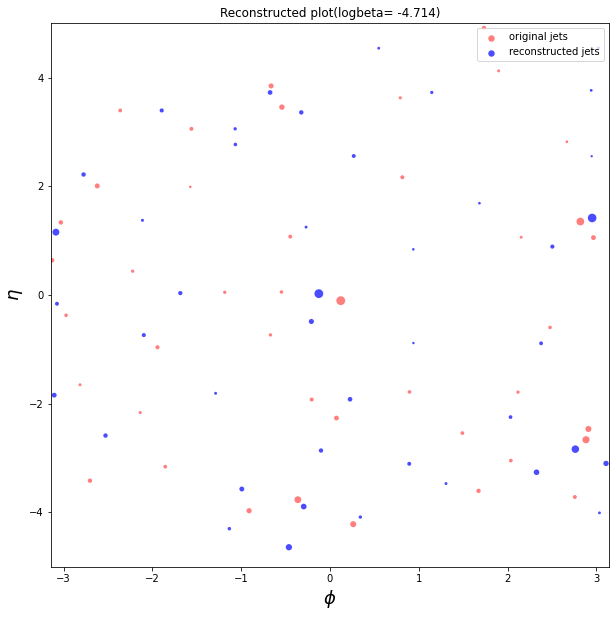

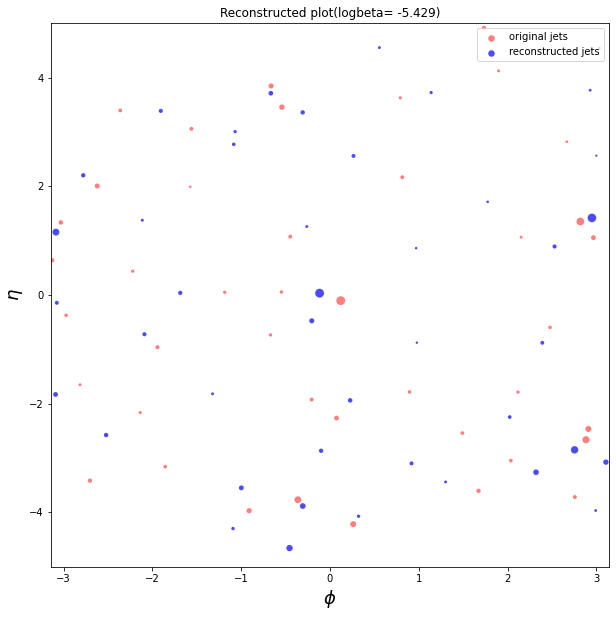

In [57]:
for jet, logbeta in zip(res[::5,0], logbetas[::5]):
    plot_jet(interesting_ys[0], jet, "Reconstructed plot(logbeta= {:.3f})".format(logbeta), 
             save_name =os.path.join("plots","Jet0", "jet0_logbeta={:.3f}.pdf".format(logbeta)))

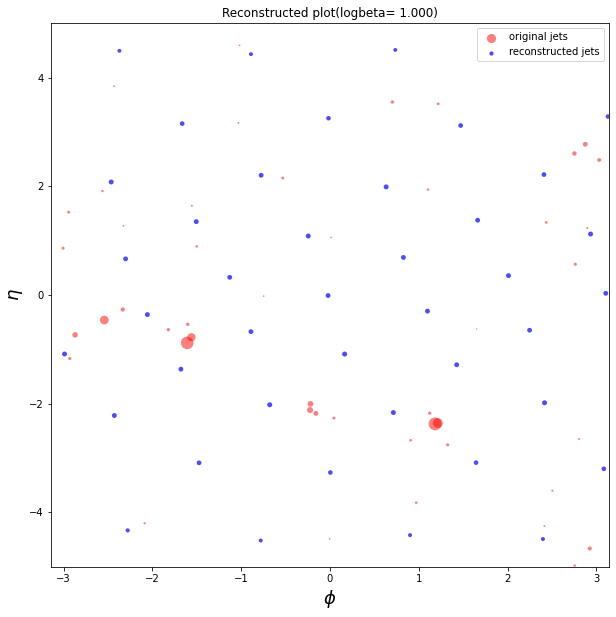

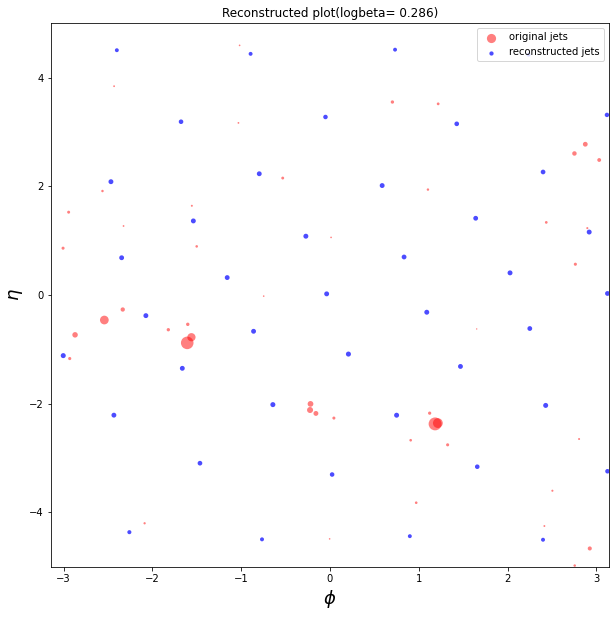

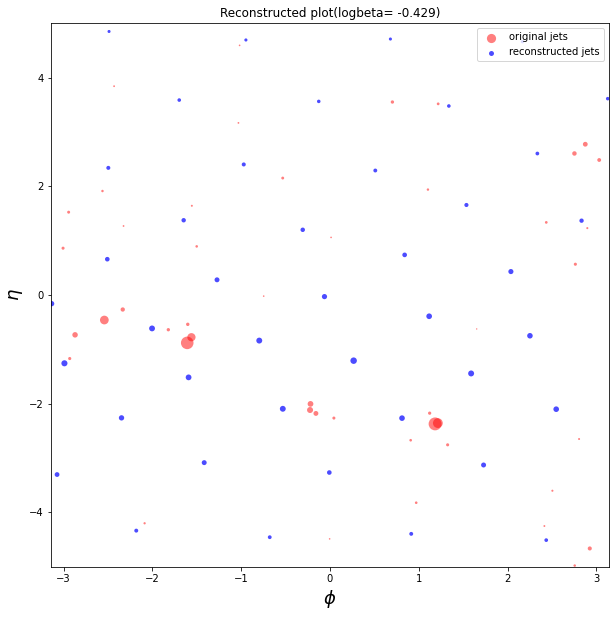

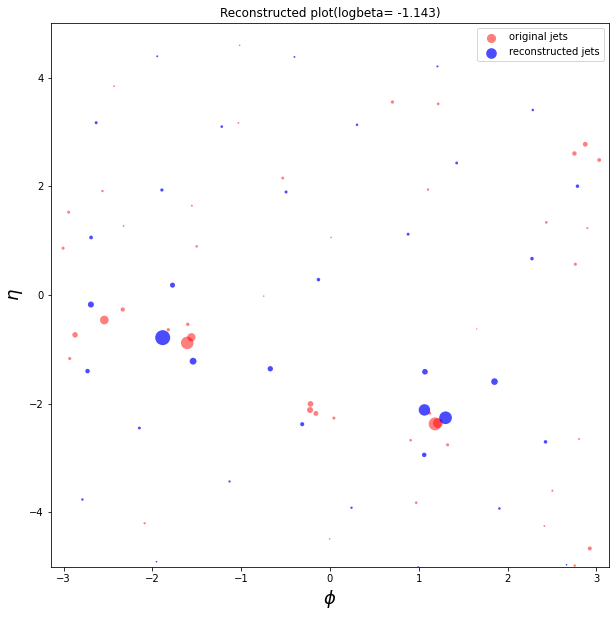

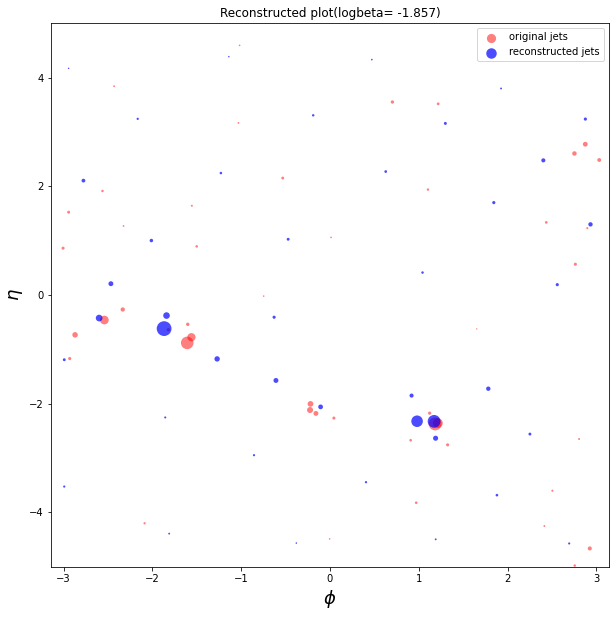

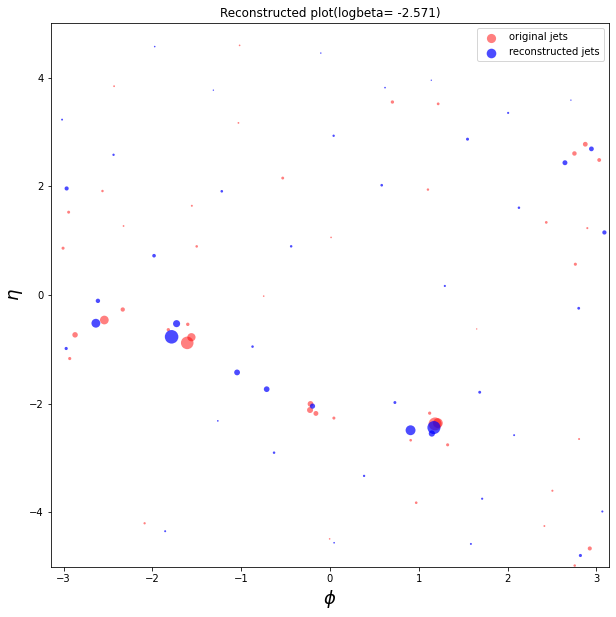

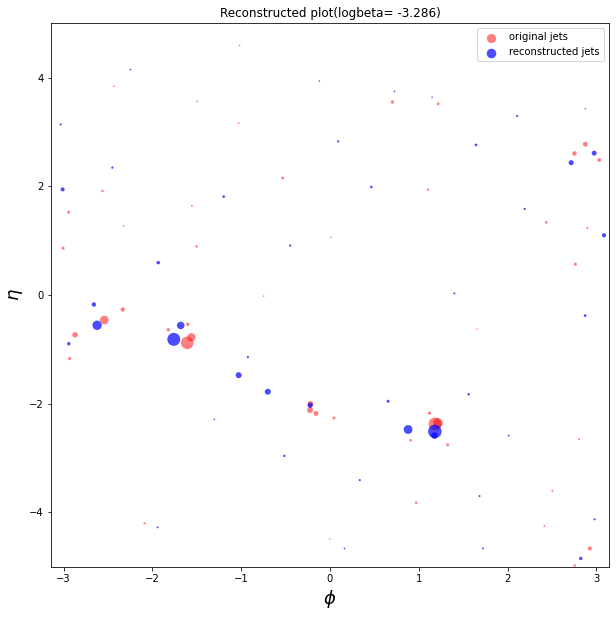

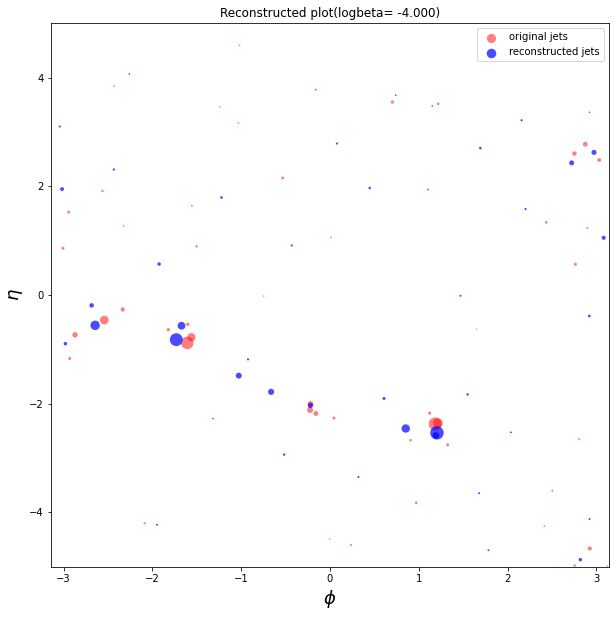

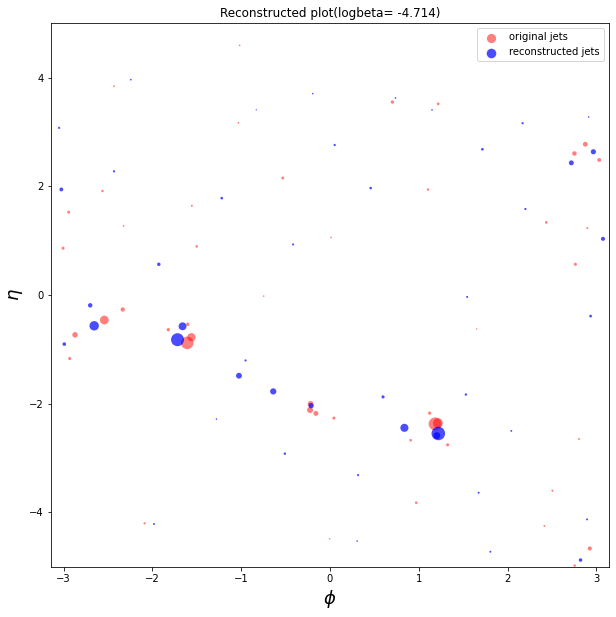

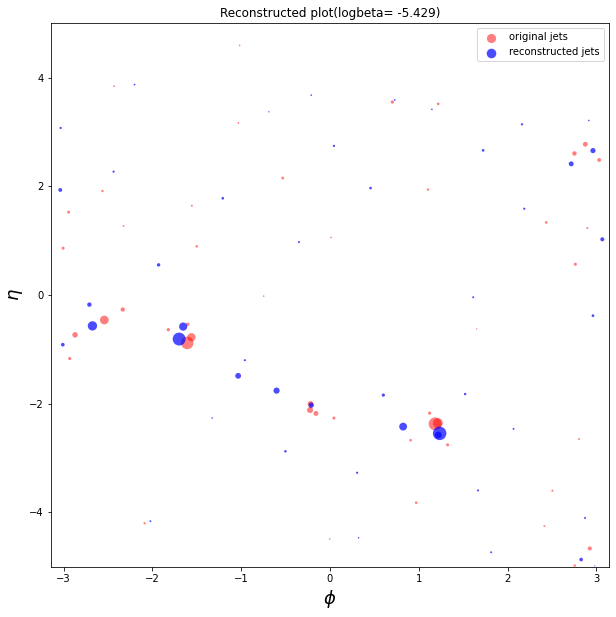

In [58]:
for jet, logbeta in zip(res[::5,1], logbetas[::5]):
    plot_jet(interesting_ys[1], jet, "Reconstructed plot(logbeta= {:.3f})".format(logbeta), 
             save_name =os.path.join("plots","Jet1", "jet1_logbeta={:.3f}.pdf".format(logbeta)))

In [ ]:
# get_mle_predict_plot(res, 
#                      interesting_validation_index, 
#                      logbetas, R=0.1, 
#                     origin_jet=interesting_ys,
#                     show_image=False,
#                      save_dir="recon_plots/mle_predict_no_anneal"
#                     )